<a href="https://colab.research.google.com/github/immahnasula/K-unity-SACCO-NPD-Loan-Prediction-/blob/main/churn_prediction_ii_triple_boost_stacking_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Churn Prediction Part 2</center></h1>
<h2><center>Triple Boosting Stacking Ensemble Model, Optuna Hyperparameter Optimization</center></h2>
<center><img src="https://uploads-ssl.webflow.com/60d45d63543dd9baaad4cb28/60d85fd90743e2299c711be5_1%20dqSLRSEC2GDV9bw_PplCYQ.png" align="center"/></center>

# Table of Contents

* [1. Introduction ](#1)
  * [1.1 Insights & Summary](#1.1)
* [2. Libraries & Configurations ](#2)
  * [2.1 Import Libraries](#2.1)
  * [2.2 Configurations](#2.2)
* [3 Dataset Overview](#3)
* [4 Data Preparation](#4)
  * [4.1 Prepare Train/Test dataset](#4.1)
  * [4.2 Encoding & Scaling](#4.2)
* [5 Modeling](#5)
  * [5.1 Utility Function](#5.1)
    * [5.1.1 Training](#5.1.1)
    * [5.1.2 Model Interpretation](#10.1.2)
  * [5.2 Catboost](#5.2)
    * [5.2.1 Training](#5.2.1)
    * [5.2.2 Optuna Tuning](#5.2.2)
  * [5.3 XGBoost](#5.3)
    * [5.3.1 Training](#5.3.1)
    * [5.3.2 Optuna Tuning](#5.3.2)
  * [5.4 LGBM](#5.4)
    * [5.4.1 Training](#5.4.1)
    * [5.4.2 Optuna Tuning](#5.4.2)
  * [5.5 Stacking Ensemble](#5.5)
    * [5.5.1 Level 0 : Base Models](#5.5.1)
    * [5.5.2 Stacking Datasets](#5.5.2)
    * [5.5.3 Level 1 : Meta Model](#5.5.3)
    * [5.5.4 Stacking Model Evaluation](#5.5.4)
    * [5.5.5 Stacking Ensemble Classic ML Models](#5.5.5)
* [6 Load Model](#6)
* [7 Conclusion](#7)
* [8 References](#8)

<a id='1'></a>
# 1 Introduction

This is a continuation of my previous notebook [Churn Prediction Part1 : EDA+Statistical Analysis](https://www.kaggle.com/ahmedshahriarsakib/churn-prediction-part1-eda-statistical-analysis)

In this notebook I applied triple gradient boosting algorithms - **XGBoost**, **Catboost** and **LightGBM** and tuned their hyperparameters using **Optuna** to predict the customer churn rate on **IBM Customer Churn Dataset**.

Dataset Source :

* [Kaggle Dataset URL](https://www.kaggle.com/blastchar/telco-customer-churn)
* [GitHub Dataset URL](https://github.com/IBM/telco-customer-churn-on-icp4d/tree/master/data)

You can also : 
* Check the **GitHub Project Repository**

[![](https://img.shields.io/badge/Customer%20Churn%20Prediction-GitHub-100000?logo=github&logoColor=white)](https://github.com/ahmedshahriar/Customer-Churn-Prediction)

* View the Project in **Jupyter Notebook Html**

[![Open in HTML](https://img.shields.io/badge/Html-Open%20Notebook-blue?logo=HTML5)](https://nbviewer.org/github/ahmedshahriar/Customer-Churn-Prediction/blob/main/Telco-Customer-Churn-Prediction.html) 

* Open The GitHub Project in **Binder**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ahmedshahriar/Customer-Churn-Prediction/main)

* View the **Streamlit App** of this Project **Live**

[![Live in Streamlit](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://share.streamlit.io//ahmedshahriar/Telco-Customer-Churn-Prediction-Streamlit-App/main/app.py)

NB: This project also serves as my assignments for the courses below - 
1. [IBM Exploratory Data Analysis for Machine Learning](https://www.coursera.org/learn/ibm-exploratory-data-analysis-for-machine-learning?specialization=ibm-machine-learning)
2. [IBM Supervised Machine Learning: Classification](https://www.coursera.org/learn/supervised-machine-learning-classification?specialization=ibm-machine-learning)


<a id='1.1'></a>

## 1.1 Insights & Summary

* Dataset mostly has categorical variables
* Imbalanced dataset, did experiment with different sampling techniques(e.g stratifying, imblearn - SMOTE)
* Optimized Hyperparameters using Optuna
* Performed single level Stacking Ensemble with Triple Gradient boosting algorithms
* Compare Boosting Stacking Ensemble with Stacking Ensemble of classic ML algorithms  

<a id='2'></a>
# 2 Libraries & Configurations

<a id='2.1'></a>
## 2.1 Import Libraries 

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 31.7 MB/s 
     |████████████████████████████████| 209 kB 63.7 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 147 kB 74.8 MB/s 
     |████████████████████████████████| 112 kB 64.5 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=738303945b6a38616234429707788e855e3a797c93d4924165972c290b98005b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
"""Import basic modules."""
import math
import os
import gc
import random
import pprint
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns

# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

"""Plotly visualization"""
from plotly.offline import init_notebook_mode

from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
                                   PowerTransformer) # convert to Gaussian-like data
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classic Algorithms
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Boosting Algorithms 
import lightgbm as lgb
# from lightgbm                         import LGBMClassifier
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier


# optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import multiprocessing
import pickle, joblib

from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))


# customize as needed
plt_params = {
    # 'figure.facecolor': 'white',
    'axes.facecolor' : 'white',

    ## to set size 
    # 'legend.fontsize': 'x-large',
    # 'figure.figsize': (15, 10),
    # 'axes.labelsize': 'x-large',
    # 'axes.titlesize': 'x-large',
    # 'xtick.labelsize': 'x-large',
    # 'ytick.labelsize': 'x-large'
}

plt.rcParams.update(plt_params)

sns.set_style('whitegrid')

init_notebook_mode(connected=True)
# pio.renderers.default='notebook' # to display plotly graph
%matplotlib inline

### Check Version

In [ ]:
#!pip freeze | optuna
#!pip freeze | grep xgboost
#!pip freeze | grep catboost
#!pip freeze | grep lightgbm
#!pip freeze | grep plotly
#!pip freeze | grep scipy
#!pip freeze | grep scikit-learn
#!pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
alembic                       1.8.1
altair                        4.2.0
anaconda-client               1.9.0
anaconda-navigator            2.2.0
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astor                         0.8.1
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopage                      0.5.1
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backp

regex                         2022.3.15
requests                      2.27.1
requests-file                 1.5.1
rope                          0.22.0
rsa                           4.7.2
Rtree                         0.9.7
ruamel-yaml-conda             0.15.100
s3transfer                    0.5.0
scikit-image                  0.19.2
scikit-learn                  1.1.2
scikit-learn-intelex          2021.20220215.102710
scipy                         1.7.3
Scrapy                        2.6.1
seaborn                       0.11.2
Send2Trash                    1.8.0
service-identity              18.1.0
setuptools                    61.2.0
sip                           4.19.13
six                           1.16.0
smart-open                    5.1.0
smmap                         5.0.0
sniffio                       1.2.0
snowballstemmer               2.2.0
sortedcollections             2.1.0
sortedcontainers              2.4.0
soupsieve                     2.3.1
Sphinx                        4.4

<a id='2.2'></a>
## 2.2 Configurations

In [6]:
# seed value
SEED = 42

# set optuna verbosity level
# default 20 
# optuna_verbosity = optuna.logging.WARNING # https://optuna.readthedocs.io/en/latest/reference/logging.html#module-optuna.logging

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

<a id='3'></a>
## 3 Dataset Overview

In [7]:
df_loan_cleaned = pd.read_csv(r'/new_loan_data-cleaned.csv')
df_loan_cleaned

,Gender,MaritalStatus,Occupation,InterestRate,DisbursedAmount,Terms,OutstandingLoan,PercentageCompleted,Terms-binned,cluster
0,F,M,F,8.0,1500000.00,36,0.000,100.00,Medium,1.0
1,F,M,F,14.0,1500333.33,36,1338555.419,10.78,Medium,0.0
2,F,M,F,15.0,50000.00,12,36705.950,26.59,Low,0.0
3,F,M,F,14.0,6000000.00,60,5739116.750,4.35,High,0.0
4,F,M,F,15.0,7500000.00,84,7360562.101,1.86,High,0.0
...,...,...,...,...,...,...,...,...,...,...
135600,F,S,F,40.0,3000.00,3,0.000,100.00,Low,1.0
135601,F,S,F,40.0,30000.00,3,0.000,100.00,Low,1.0
135602,F,S,F,40.0,30000.00,3,0.000,100.00,Low,1.0
135603,F,S,F,40.0,10000.00,3,0.000,100.00,Low,1.0


In [8]:
printmd("**Column Info**")
display(df_loan_cleaned.info())
printmd("<br>**Datatypes Count**")
display(df_loan_cleaned.dtypes.value_counts())
printmd("<br>**Categorical Features**")
display(df_loan_cleaned.describe(include=['object']).T)

**Column Info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135605 entries, 0 to 135604
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               135605 non-null  object 
 1   MaritalStatus        135605 non-null  object 
 2   Occupation           135605 non-null  object 
 3   InterestRate         135605 non-null  float64
 4   DisbursedAmount      135605 non-null  float64
 5   Terms                135605 non-null  int64  
 6   OutstandingLoan      135605 non-null  float64
 7   PercentageCompleted  135605 non-null  float64
 8   Terms-binned         135605 non-null  object 
 9   cluster              135605 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 10.3+ MB


None

<br>**Datatypes Count**

float64    5
object     4
int64      1
dtype: int64

<br>**Categorical Features**

,count,unique,top,freq
Gender,135605,3,M,79825
MaritalStatus,135605,3,M,97978
Occupation,135605,4,F,86067
Terms-binned,135605,3,Low,121298


<a id='4'></a>
# 4 Data Preparation

<a id='4.1'></a>
## 4.1 Prepare Train/Test dataset

In [9]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df_loan_cleaned, df_loan_cleaned["cluster"]):
    strat_train_set = df_loan_cleaned.loc[train_index]
    strat_test_set = df_loan_cleaned.loc[test_index]

print('Target Labels Ratio in Original Dataset\n')
print(df_loan_cleaned["cluster"].value_counts(normalize=True).sort_index())
# df_loan_cleaned["cluster"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["cluster"].value_counts(normalize=True).sort_index())
# strat_test_set["cluster"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

0.0    0.46982
1.0    0.53018
Name: cluster, dtype: float64

Target Labels Ratio in Test Dataset

0.0    0.46982
1.0    0.53018
Name: cluster, dtype: float64


In [10]:
# train Dataset
X = strat_train_set.drop("cluster", axis=1)
y = strat_train_set["cluster"].copy()

# test dataset
y_test = strat_test_set['cluster'].values
X_test = strat_test_set.drop('cluster',axis=1)

X.shape, y.shape, X_test.shape, y_test.shape

((108484, 9), (108484,), (27121, 9), (27121,))

In [11]:
# Check cardinality of categorical variables : 

# reinitiate cat_cols because 'customerID' is still included in cat_cols variable
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
num_cols = list(set(X._get_numeric_data().columns))# already converted
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), cat_cols))
d = dict(zip(cat_cols, object_nunique))

print("Number of unique entries by column, in ascending order:\n")

sorted_cols_by_cardinality = sorted(d.items(), key=lambda x: x[1])
display(pd.DataFrame(sorted_cols_by_cardinality, columns=['Columns', 'Cardinality']))

print("Total Categorical Columns",len(cat_cols))
print("Total Numerical Columns",len(num_cols))

printmd("**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**")

Number of unique entries by column, in ascending order:



,Columns,Cardinality
0,MaritalStatus,3
1,Gender,3
2,Terms-binned,3
3,Occupation,4


Total Categorical Columns 4
Total Numerical Columns 5


**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**

<a id='4.2'></a>
## 4.2 Encoding & Scaling

In [15]:
ordinal_encoder = OrdinalEncoder()
X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

le = LabelEncoder()
y = le.fit_transform(y)

y_test = le.fit_transform(y_test)


num_cols = ['InterestRate', 'DisbursedAmount', 'Terms', 'OutstandingLoan', 'PercentageCompleted']

transformer = RobustScaler()
X[num_cols] = transformer.fit_transform(X[num_cols])
X_test[num_cols] = transformer.transform(X_test[num_cols])

### Correlation Heatmap

**Pearson’s R** (parametric) is not applicable when the data is categorical

**Kendall’s Tau** is a non-parametric measure of relationships between continuous or ordinal features

While Pearson's correlation assesses linear relationships, **Spearman's correlation** (non -parametric) assesses monotonic relationships (whether linear or not)


Most of the features in this dataset are categorical and nominal, so it's ineffective for those non-numerical attributes 

Moreover, there are only **three numerical features** which are not normally distributed

Therefore, `pandas.corr()` is not feasible to use for this case


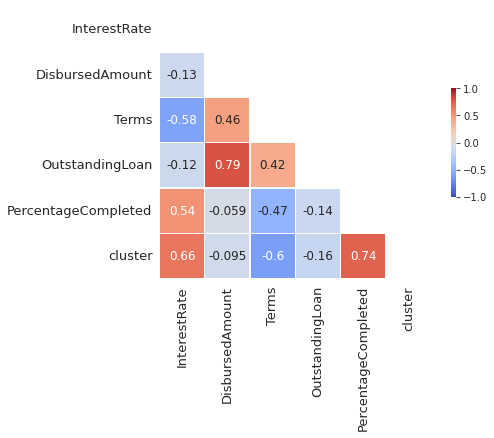

In [16]:
# Correlation Matrix
# only numerical output
corr_matrix = pd.concat([X[num_cols],strat_train_set[["cluster"]]],axis=1).corr() # 'spearman' / 'pearson' / 'kendall'

# Set Up Mask To Hide Upper Triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0, fontsize=13)
ax.set_xticklabels(corr_matrix.columns, fontsize=13)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.show()


<a id='5'></a>
# 5 Modeling

<a id='5.1'></a>
## 5.1 Utility Function

<a id='5.1.1'></a>
### 5.1.1 Training

In [19]:
def train_model(model, model_name, X, y, X_test, fold):
    printmd(f'**{model_name} Init**')
    auc_scores = []

    test_preds=None

    strat_kf = StratifiedKFold(n_splits=fold, random_state=SEED, shuffle=True)

    for fold, (train_index, valid_index) in enumerate(strat_kf.split(X, y)):
        X_train, X_valid = X.iloc[train_index] , X.iloc[valid_index]
        y_train, y_valid = y[train_index] , y[valid_index]


        #### to SMOTE sampling
        # sm = SMOTE(sampling_strategy='all', random_state=SEED)
        # X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        # X_val_oversampled, y_val_oversampled = sm.fit_resample(X_valid, y_valid)

        eval_set = [(X_valid, y_valid)]

        print("-" * 50)
        print(f"Fold {fold + 1}")

        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set= eval_set, verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)


        val_pred = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, val_pred) # AUROC requires probabilities of the predictions
        print("AUC Score : ",auc)

        auc_scores.append(auc)

        if test_preds is None:
            test_preds = model.predict_proba(X_test)[:,1] 
        else:
            test_preds += model.predict_proba(X_test)[:,1] 


        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print("-" * 50)
    test_preds /= fold

    print(f'Train : Base Model - {model_name} - AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

    # evaluation on test set
    print(f'Test  : Base Model - {model_name} - AUC score : {roc_auc_score(y_test, test_preds)}')

    del test_preds
    gc.collect()

    print('Done!')

    if model_name == 'cat':
        plot_feature_importance(model.get_feature_importance(), X.columns, model_name)
        model.save_model("model_catboost")

    elif model_name == 'xgb':
        plot_feature_importance(model.feature_importances_, X.columns, model_name)

        # https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
        # save the model
        model.save_model('model_xgb.json')

    else:
        plot_feature_importance(model.feature_importances_, X.columns, model_name)
        model.booster_.save_model('model_lgbm.txt') 
        joblib.dump(model, 'model_lgbm.pkl')

<a id='5.1.2'></a>
### 5.1.2 Model Interpretation

In [26]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8),dpi=100)
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# credit : https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

<a id='5.2'></a>
## 5.2 Catboost

<a id='5.2.1'></a>
### 5.2.1 Training

**cat Init**

--------------------------------------------------
Fold 1
AUC Score :  0.999998755028661
--------------------------------------------------
Fold 2
AUC Score :  1.0
--------------------------------------------------
Fold 3
AUC Score :  0.9999990620078952
--------------------------------------------------
Fold 4
AUC Score :  1.0
--------------------------------------------------
Fold 5
AUC Score :  0.999999744133772
--------------------------------------------------
Fold 6
AUC Score :  0.9999999658845029
--------------------------------------------------
Fold 7
AUC Score :  0.9999994541642441
--------------------------------------------------
Fold 8
AUC Score :  0.9999991471316314
--------------------------------------------------
Fold 9
AUC Score :  1.0
--------------------------------------------------
Fold 10
AUC Score :  0.9999996076805505
--------------------------------------------------
Train : Base Model - cat - AUC score : mean ---> 0.9999995736031255, std ---> 4.309880451213388

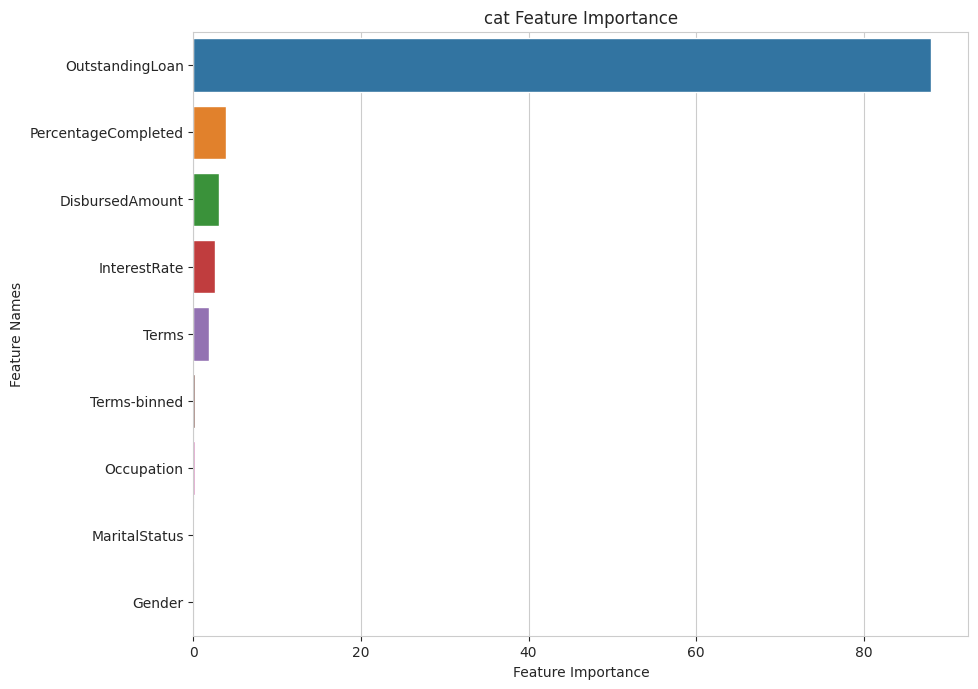

In [27]:
%%time
# https://catboost.ai/en/docs/concepts/speed-up-training

# this dataset is fairly small, so catboost runs super slow on GPU
# https://github.com/catboost/catboost/issues/1034


fold_num = 10

# convert datatype to integer -> use 'cat_features' parameter
# it does not improve score, feel free to try it out
# for c in cat_cols:
#     X[c] = X[c].astype(np.int)
#     X_test[c] = X_test[c].astype(np.int)

cat_params  = {
    'eval_metric':"AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian', 
    'colsample_bylevel': 0.013457968759952536, # does not support on gpu https://catboost.ai/en/docs/references/training-parameters/common#rsm
    'depth': 6,
    'iterations': 6888,
    'learning_rate': 0.05683590866750785,
    'random_strength': 18, 
    'l2_leaf_reg': 50,
    'random_state': SEED,
#     'task_type':"GPU",
#     'devices' : '0',
    # 'cat_features':cat_cols
    }


cat = CatBoostClassifier(**cat_params)

train_model(cat, 'cat', X, y, X_test, fold_num)

<a id='5.2.2'></a>
### 5.2.2 Optuna Tuning

In [28]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)
    
    # parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 6000, 8000), 
        'depth' : trial.suggest_int('depth', 3, 12),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.1), #  # does not support on gpu 
        'random_strength' :trial.suggest_int('random_strength', 0, 100),   
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]  # https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options
        ),
        'random_state': trial.suggest_categorical('random_state',[SEED]),
    }

    # learning
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        # task_type="GPU",
        l2_leaf_reg=50,
#         border_count=64,
        **params
    )        
    model.fit(X_train, y_train, 
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial
    
    return auc

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [29]:
%%time
n_trials = int(100)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[I 2022-08-26 18:57:56,387] A new study created in memory with name: no-name-0e85ca7d-483f-41b9-8274-1bbd6f46ac42
[I 2022-08-26 18:59:27,124] Trial 0 finished with value: 1.0 and parameters: {'iterations': 7362, 'depth': 6, 'learning_rate': 0.01636489110203043, 'objective': 'Logloss', 'colsample_bylevel': 0.0833093142313227, 'random_strength': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_state': 42}. Best is trial 0 with value: 1.0.
[I 2022-08-26 18:59:39,120] Trial 1 finished with value: 1.0 and parameters: {'iterations': 6574, 'depth': 5, 'learning_rate': 0.004794206957054216, 'objective': 'Logloss', 'colsample_bylevel': 0.04735555143553053, 'random_strength': 40, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'random_state': 42}. Best is trial 0 with value: 1.0.
[I 2022-08-26 19:00:54,055] Trial 3 finished with value: 1.0 and parameters: {'iterations': 6125, 'depth': 10, 'learning_rate': 0.03582483403627642, 'objective': 'Logloss', 'colsample_bylevel': 0.

**BEST TRIAL**

Best Score:  1.0


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.0833093142313227,
 'depth': 6,
 'iterations': 7362,
 'learning_rate': 0.01636489110203043,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 19}
CPU times: user 4h 59min 24s, sys: 9min, total: 5h 8min 24s
Wall time: 2h 38min 28s


In [24]:
# Save
pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

ValueError: ignored

<a id='5.3'></a>
## 5.3 XGBoost

<a id='5.3.1'></a>
### 5.3.1 Training

In [ ]:
%%time
fold_num = 10


# https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x

xgb_params = {'colsample_bytree': 0.2645340949128848,
#'eval_metric': 'auc',
'tree_method': 'gpu_hist',
'gpu_id': 0,
'predictor': 'gpu_predictor',
'gamma': 0,
'learning_rate': 0.001851851953410451,
'max_depth': 3,
'n_estimators': 6000,
'random_state': SEED,
'reg_lambda': 0.1,
'subsample': 0.6905005604726816,
'use_label_encoder': False }


xgb = XGBClassifier(**xgb_params)

train_model(xgb, 'xgb', X, y, X_test, fold_num)

<a id='5.3.2'></a>
### 5.3.2 Optuna Tuning

In [ ]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    params  = {
          'n_estimators': trial.suggest_categorical('n_estimators',[10000]),  
          'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
          'max_depth': trial.suggest_int('max_depth',3,12),
          'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,0.99,log=True), 
          'subsample': trial.suggest_float('subsample',0.2,0.99,log=True),
          'eval_metric': trial.suggest_categorical('eval_metric',['auc']),
          'use_label_encoder':trial.suggest_categorical('use_label_encoder',[False]),
          'gamma': trial.suggest_categorical('gamma',[0, 0.25, 0.5, 1.0]),
          'reg_lambda': trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
          'tree_method': trial.suggest_categorical('tree_method',['gpu_hist']),
          'gpu_id': trial.suggest_categorical('gpu_id',[0]),
          'predictor' : trial.suggest_categorical('predictor',['gpu_predictor']),
          'random_state': trial.suggest_categorical('random_state',[SEED])
         }

    # learning
    model = XGBClassifier(**params)        
    model.fit(X_train, y_train, 
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial
    
    return auc

In [ ]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# Save
pickle.dump(study.best_trial.params, open('XGB_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)


# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

<a id='5.4'></a>
## 5.4 LGBM

<a id='5.4.1'></a>
### 5.4.1 Training

**lgbm Init**

--------------------------------------------------
Fold 1
AUC Score :  0.8239533011272142
--------------------------------------------------
Fold 2
AUC Score :  0.8613526570048309
--------------------------------------------------
Fold 3
AUC Score :  0.8340982286634462
--------------------------------------------------
Fold 4
AUC Score :  0.8305152979066022
--------------------------------------------------
Fold 5
AUC Score :  0.8392990305741983
--------------------------------------------------
Fold 6
AUC Score :  0.856328826638135
--------------------------------------------------
Fold 7
AUC Score :  0.8692409947151704
--------------------------------------------------
Fold 8
AUC Score :  0.858395746198489
--------------------------------------------------
Fold 9
AUC Score :  0.8547320299581753
--------------------------------------------------
Fold 10
AUC Score :  0.8681275221953186
--------------------------------------------------
Train : Base Model - lgbm - AUC score : mean ---> 

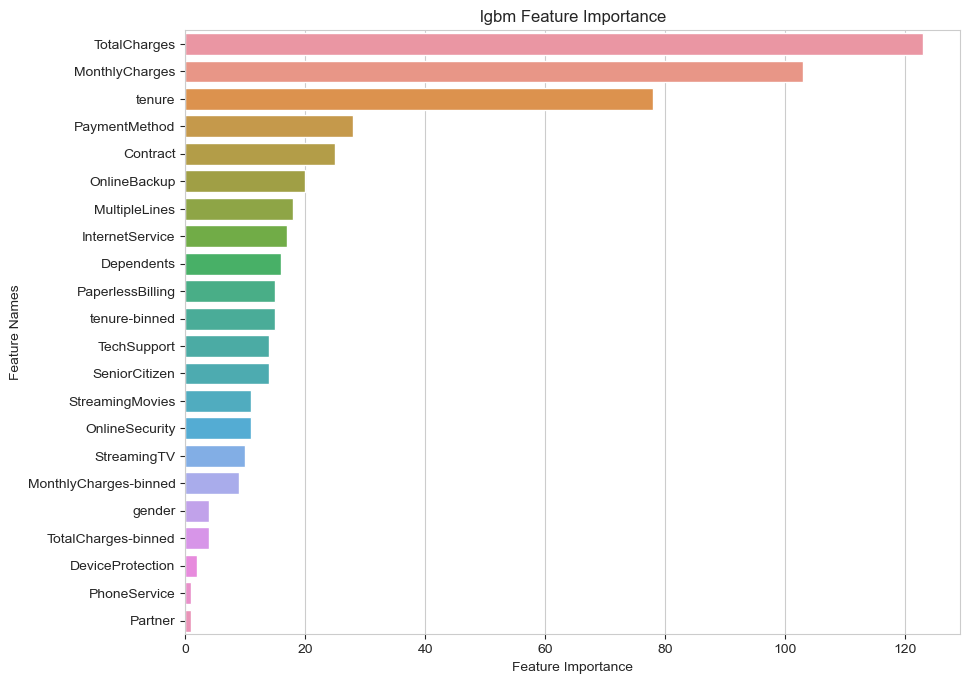

In [ ]:
%%time
# highly recommended : https://neptune.ai/blog/lightgbm-parameters-guide

fold_num = 10

# convert datatype to category to use 'categorical_feature' parameter
# it does not improve score, feel free to try it out
# for c in cat_cols:
#     X[c] = X[c].astype('category')
#     X_test[c] = X_test[c].astype('category')

lgbm_params = {'n_estimators': 12749, 
               'learning_rate': 0.1985328656822506, 
               'reg_alpha': 9.77289653841389, 
               'reg_lambda': 4.979048257991328, 
               'num_leaves': 921, 
               'min_child_samples': 85, 
               'max_depth': 56, 
               'colsample_bytree': 0.43848926369957975, 
               'cat_smooth': 92, 
               'cat_l2': 17, 
               'device': 'gpu',
               'gpu_platform_id': 0,
               'gpu_device_id': 0,
               'min_data_per_group': 59,
               'random_state': SEED,
              #  'is_unbalance':True,  # does not improve score
              # 'categorical_feature': cat_cols, # does not improve score
               }


lgbm = lgb.LGBMClassifier(**lgbm_params)

train_model(lgbm, 'lgbm', X, y, X_test, fold_num)

<a id='5.4.2'></a>
### 5.4.2 Optuna Tuning

In [ ]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    params = {
        'objective': 'binary', # binary target
        'n_estimators': trial.suggest_int('n_estimators', 4000, 20000),
        'learning_rate' : trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000), # num leaves = 2^max_depth
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'random_state': int(SEED),
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        
        #     'subsample': 0.6,
        #     'subsample_freq': 1,
        #     'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
    }

    # Learning
    model = lgb.LGBMClassifier(**params)        
    model.fit(X_train, y_train, 
              verbose=False) # 1000
    val_pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_pred) # AUROC requires probabilities of the predictions

    # print("AUC Score : ",auc) # check the auc score in each trial
    
    return auc

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**LGBM Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

In [ ]:
# Save
pickle.dump(study.best_trial.params, open('LGBM_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)
printmd('**LGBM Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

<a id='5.5'></a>
## 5.5 Stacking Ensemble

---
![image.png](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png)

In [ ]:
def stacking_data_loader(model, model_name, train, y, test, fold):
    '''
    input train, test datasets and fold value!
    returns train, test datasets for stacking ensemble
    '''

    stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = True)
    
    # Declaration Pred Datasets
    train_fold_pred = np.zeros((train.shape[0], 1))
    test_pred = np.zeros((test.shape[0], fold))
    
    for counter, (train_index, valid_index) in enumerate(stk.split(train, y)):
        X_train, y_train = train.iloc[train_index], y[train_index]
        X_valid, y_valid = train.iloc[valid_index], y[valid_index]

        print('------------ Fold', counter+1, 'Start! ------------')
        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)
            
        print('------------ Fold', counter+1, 'Done! ------------')
        
        train_fold_pred[valid_index, :] = model.predict_proba(X_valid)[:, 1].reshape(-1, 1)
        test_pred[:, counter] = model.predict_proba(test)[:, 1]
        del X_train, y_train, X_valid, y_valid
        gc.collect()
        
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)
    
    del test_pred
    gc.collect()
    
    print('Done!')
    
    return train_fold_pred, test_pred_mean

# Thanks to : https://www.kaggle.com/junhyeok99/stacking-ensemble-tutorial

<a id='5.5.1'></a>
### 5.5.1 Level 0 : Base Models

In [ ]:
%%time
lgbm_params = {'n_estimators': 12749, 
               'learning_rate': 0.1985328656822506, 
               'reg_alpha': 9.77289653841389, 
               'reg_lambda': 4.979048257991328, 
               'num_leaves': 921, 
               'min_child_samples': 85, 
               'max_depth': 56, 
               'colsample_bytree': 0.43848926369957975, 
               'cat_smooth': 92, 
               'cat_l2': 17, 
               'device': 'gpu',
               'gpu_platform_id': 0,
               'gpu_device_id': 0,
               'min_data_per_group': 59,
               'random_state': SEED,
              #  'is_unbalance':True,  # does not improve score
              # 'categorical_feature': cat_cols, # does not improve score
               }


lgbm = lgb.LGBMClassifier(**lgbm_params)


xgb_params = {'colsample_bytree': 0.2645340949128848,
            'eval_metric': 'auc',
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'predictor': 'gpu_predictor',
            'gamma': 0,
            'learning_rate': 0.001851851953410451,
            'max_depth': 3,
            'n_estimators': 6000,
            'random_state': SEED,
            'reg_lambda': 0.1,
            'subsample': 0.6905005604726816,
            'use_label_encoder': False }

xgb = XGBClassifier(**xgb_params)


cat_params  = {'eval_metric':"AUC",
              #  'task_type':"GPU",
              'loss_function': 'logloss',
              'boosting_type': 'Plain',
              'bootstrap_type': 'Bayesian', # 0.846998114133664
              'colsample_bylevel': 0.013457968759952536,
              'depth': 6,
              'iterations': 6888,
              'learning_rate': 0.05683590866750785,
              'objective': 'Logloss',
              'random_strength': 18, 
              'l2_leaf_reg': 50,
              'random_state': SEED,
              # 'cat_features':cat_cols
              }


cat = CatBoostClassifier(**cat_params)

fold_num = 5

cat_train, cat_test = stacking_data_loader(cat, 'cat', X, y, X_test, fold_num)
del cat
gc.collect()

lgbm_train, lgbm_test = stacking_data_loader(lgbm, 'lgbm', X, y, X_test, fold_num)
del lgbm
gc.collect()

xgb_train, xgb_test = stacking_data_loader(xgb, 'xgb', X, y, X_test, fold_num)
del xgb
gc.collect()

<a id='5.5.2'></a>
### 5.5.2 Stacking Datasets

In [ ]:
stack_X_train = np.concatenate((cat_train, lgbm_train, xgb_train), axis = 1)
stack_X_test = np.concatenate((cat_test, lgbm_test, xgb_test), axis = 1)

del cat_train, lgbm_train, xgb_train, cat_test, lgbm_test, xgb_test
gc.collect()

stack_X_train.shape, stack_X_test.shape

<a id='5.5.3'></a>
### 5.5.3 Level 1 : Meta Model

In [ ]:
# meta model : LogisticRegression
fold = 5
stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = False)
test_pred_log_reg = np.zeros((stack_X_test.shape[0], fold))
auc_scores = []

for counter, (train_index, valid_index)in enumerate(stk.split(stack_X_train, y)):
    X_train, y_train = stack_X_train[train_index], y[train_index]
    X_valid, y_valid = stack_X_train[valid_index], y[valid_index]

    #### to SMOTE sampling, not advised, low performance
    # sm = SMOTE(sampling_strategy='all', random_state=SEED)
    # X_train, y_train = sm.fit_resample(X_train, y_train)
    # X_valid, y_valid = sm.fit_resample(X_valid, y_valid)
    
    lr = LogisticRegression(n_jobs = -1, random_state = SEED, C = 0.3, max_iter = 10000)
    lr.fit(X_train, y_train)
    
    valid_pred_log_reg = lr.predict_proba(X_valid)[:, 1]
    test_pred_log_reg[:, counter] = lr.predict_proba(stack_X_test)[:, 1]

    auc = roc_auc_score(y_valid, valid_pred_log_reg)
    auc_scores.append(auc)

    print('Fold', counter+1 , 'AUC :', auc)
    fold += 1

test_pred_log_reg_mean = np.mean(test_pred_log_reg, axis = 1).reshape(-1, 1)

print(f'AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

plt.boxplot(auc_scores, showmeans=True)

plt.show()

# AUC score : mean ---> 0.8495059939911511, std ---> 0.014576136833225574

<a id='5.5.4'></a>
### 5.5.4 Stacking Model Evaluation

In [ ]:
roc_auc_score_log_reg = roc_auc_score(y_test, test_pred_log_reg_mean)

printmd(f"AUC on the test dataset : **{roc_auc_score_log_reg}**")

#### ROC Curve

In [ ]:
plt.figure(figsize=(10,8))

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, test_pred_log_reg_mean)

# plot model roc curve
font_size = 15
plt.plot(fpr, tpr, marker='.', label=f'Logistic (area = {roc_auc_score_log_reg:0.2f})')

# axis labels
plt.xlabel('False Positive Rate', fontsize=font_size)
plt.ylabel('True Positive Rate', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
# curve title
plt.suptitle('ROC Curve', fontsize=20)
# show the legend
plt.legend()

# show the plot
plt.show()

#### PR Curve

In [ ]:
plt.figure(figsize=(10,8))

# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)

# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, test_pred_log_reg_mean)

# plot the model precision-recall curve
font_size = 15
plt.plot(recall, precision, marker='.', label='Logistic')

# title PR curve
plt.suptitle('PR Curve', fontsize=20)

# axis labels
plt.xlabel('Recall', fontsize=font_size)
plt.ylabel('Precision', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
# show the legend
plt.legend()

# show the plot
plt.show()

<a id='5.5.5'></a>
### 5.5.5 Stacking Ensemble Classic ML Models

In [ ]:
# 5 fold stacking ensembling with 3 Repeated Stratified 10-Fold cross validation

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('logreg', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('rforest', RandomForestClassifier()))
    level0.append(('etree', ExtraTreesClassifier()))
    level0.append(('svm', SVC()))

    # define meta learner model
    level1 = LogisticRegression()

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['logreg'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['rforest'] = RandomForestClassifier()
    models['etree'] = ExtraTreesClassifier()
    models['svm'] = SVC()
    models['stacking'] = get_stacking()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

printmd("**Model Evaluation :**")

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s, cross-validation score - mean  : %.3f std: (%.3f)' % (name, np.mean(scores), np.std(scores)))
 
printmd("<br>")

# plot model performance for comparison
font_size = 15
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)

plt.title("Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("Cross-val Score",  fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.show()


# credit : https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python

**Classic ML models perform poorly in comparison with Gradient Boosting models**

<a id='6'></a>
# 6 Load Model

## Model Files

In [ ]:
import os
os.listdir('./')

In [ ]:
def get_classifier(clf_name):
    if clf_name == 'XGBoost':
        clf = XGBClassifier()  # init model
        clf.load_model("./model_xgb.json")
    if clf_name == 'Catboost':
        clf = CatBoostClassifier()  # parameters not required.
        clf.load_model('./model_catboost')
    if clf_name == 'LGBM':
        clf = lgb.Booster(model_file='./model_lgbm.txt')
    return clf


models = ['XGBoost', 'Catboost', 'LGBM']
printmd("**Classifiers | Churn Predictions, Probability (Churn=True)**")
for model in models:
    
    clf = get_classifier(model)
    
    try:
        # xgboost,
        test_pred = clf.predict_proba(X_test[:3])[:, 1]  # probability of getting 1
        # check for first three instances of test dataset
    except AttributeError as ae:
        
        # lgbm load model
        # https://github.com/Microsoft/LightGBM/issues/1217
        
        test_pred = clf.predict(X_test[:3])
    print(model.ljust(12),'|' , test_pred)

<a id='7'></a>
# 7 Conclusion

* Number of months the customer has stayed with the company (**tenure**) and the contract term of the customer (**contract**) are the most important features that have strong correlation with churn of the customer 
* Results from statiscial hypotheses testing reflects **similarity** with model feature importance
* With 80/20 train/test split triple boosting stacking ensemble model achieved an AUC of **~0.85**

## What's Next ?

---
Project deployment
---

#### I deployed the project using [**streamlit**](https://streamlit.io)

#### Streamlit App Preview

![Telco Customer Churn Prediction Streamlit](https://user-images.githubusercontent.com/40615350/142819900-60053284-5266-4a66-87a3-cddcb2f0d929.gif "Telco Customer Churn Prediction Streamlit")

---

#### Please click the button below if you want to check the live app

[![Live in Streamlit](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://share.streamlit.io//ahmedshahriar/Telco-Customer-Churn-Prediction-Streamlit-App/main/app.py)

---

### If you like this project please feel free to fork the kernel,use the code, share the notebook and give an upvote. If you have any questions or suggestions to improve the analysis please comment below

<a id='8'></a>
# 8 Reference

****

1. [Notes on XGBoost Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
2. [Understanding LightGBM Parameters (and How to Tune Them)](https://neptune.ai/blog/lightgbm-parameters-guide)
3. [Approaching (Almost) Any Machine Learning Problem - LinkedIn Article](https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur/)
4. [Parameter tuning - catboost.ai](https://catboost.ai/en/docs/concepts/parameter-tuning)